# Makie.jl の sysimage を作成して初回起動を高速化する

[参考](https://zenn.dev/kb_satou/articles/3d7f1f70aea885)

## Makie.jl の sysimage 作成

[Makie.jl](https://makie.juliaplots.org/stable/) は純 Julia 製のプロットパッケージであり、非常に複雑なコードで形成されているため、初回のプロット表示に1分以上かかる

流石に遅すぎて使いにくいため、[PackageCompiler.jl](https://github.com/JuliaLang/PackageCompiler.jl) を使って sysimage を作成してみる

### sysimage とは
Julia は JITコンパイラを採用しており、コードを Just-in-Time 方式でコンパイルしてから実行している

このとき、初回実行時のコンパイルしたコードの状態を保存したものが sysimage である

sysimage を使うことで、JITコンパイルの時間を削減し、初回実行を高速化することができる

In [1]:
using Pkg

# PackageCompiler.jl インストール
Pkg.add("PackageCompiler")

    Updating registry at `C:\Users\user\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\user\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.7\Manifest.toml`


In [1]:
using PackageCompiler

# sysimage 化するコードの作成
## ./MakieSysImage.jl
# * GLMakie パッケージのみを sysimage 化しても良いのだが
##  特にコンパイル時間が多くかかるのは図・軸の作成部分であるため
##  図・軸の作成を行うコードを含めて sysimage 化した方が速くなる
inputfile = "./MakieSysImage.jl"
open(inputfile, "w") do fp
    write(fp, """
using GLMakie

fig = Figure()
plt = fig[1, 1]
ax = Axis(plt)
    """)
end

# sysimage の出力先ディレクトリの作成
## $HOME/.julia/sysimage/GLMakie.dylib
outputdir = joinpath(homedir(), ".julia", "sysimage")
outputfile = joinpath(outputdir, "GLMakie.dylib")
if !isdir(outputdir)
    mkdir(outputdir)
end

# sysimage 作成
## => 4分弱で完了
@time create_sysimage(
    [:GLMakie];
    precompile_execution_file = inputfile,
    sysimage_path = outputfile
)

224.802117 seconds (19.42 M allocations: 1.021 GiB, 0.19% gc time, 2.52% compilation time)


┌ Info: PackageCompiler: Executing d:\github\julia_ml-tuto\etc\visualization\makie\MakieSysImage.jl => C:\Users\user\AppData\Local\Temp\jl_packagecompiler_X9Ez0P\jl_3577.tmp
└ @ PackageCompiler C:\Users\user\.julia\packages\PackageCompiler\X7R0D\src\PackageCompiler.jl:237
┌ Info: PackageCompiler: Done
└ @ PackageCompiler C:\Users\user\.julia\packages\PackageCompiler\X7R0D\src\PackageCompiler.jl:239
- PackageCompiler: compiling incremental system image


## Jupyter Kernel with sysimage 作成

Jupyter 上で作成した sysimage を使うえるようにするには、sysimage を読み込む Jupyter Kernel を別途作成する必要がある

IJulia 環境においては `IJulia.installkernel` 関数で Jupyter Kernel を作成することができる

In [2]:
using IJulia

# installkernel(kernel_name::String, kernel_option::String)
## --sysimage オプション: 読み込む sysimage を絶対パスで指定
installkernel("Julia 1.7 with sysimage", "--sysimage=$(outputfile)")

# => 以降 Julia 1.7 with sysimage カーネルを利用すれば GLMakie を高速起動できる

┌ Info: Installing Julia 1.7 with sysimage kernelspec in C:\Users\user\AppData\Roaming\jupyter\kernels\julia-1.7-with-sysimage-1.7
└ @ IJulia C:\Users\user\.julia\packages\IJulia\AQu2H\deps\kspec.jl:94


"C:\\Users\\user\\AppData\\Roaming\\jupyter\\kernels\\julia-1.7-with-sysimage-1.7"

  0.002006 seconds (1.23 k allocations: 79.641 KiB, 84.70% compilation time)
  1.799684 seconds (5.84 M allocations: 334.678 MiB, 4.26% gc time, 94.30% compilation time)


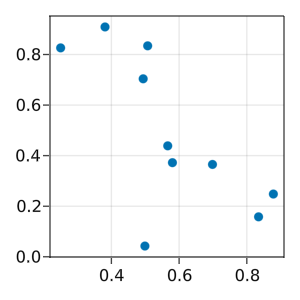

In [1]:
@time using GLMakie
@time (() -> begin
    fig = Figure(resolution=(300, 300))
    plt = fig[1, 1]
    ax = Axis(plt)

    scatter!(plt, rand(10, 2))
    fig
end)()